In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from collections import defaultdict
import pandas as pd
from nltk import word_tokenize
import re
import numpy as np
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange
import transformers

In [3]:
target_length_range = (5, 10)

In [4]:
# regex implementation here differs slightly from the one used to do the efficient search;
# prepare to filter the results so we know we are consistent
with open("final_word_re.txt") as f:
    word_re = re.compile(f.read(), re.IGNORECASE)

In [5]:
!wc -l matches.opensubtitles-en.txt

8991155 matches.opensubtitles-en.txt


In [6]:
matches = defaultdict(list)

with open("matches.opensubtitles-en.txt", "r") as f:
    for line in tqdm(f, total=8991155):
        word, sent = line.strip().split("\t", 1)
        toks = word_tokenize(sent)
        if len(toks) >= target_length_range[0] and len(toks) <= target_length_range[1]:
            matches[word].append(sent)

  0%|          | 0/8991155 [00:00<?, ?it/s]

In [7]:
matches = {k: list(set(ms)) for k, ms in matches.items()}

In [8]:
# Preprocess sentences
def preprocess_sentence(sentence, target_word):
    # make sure target word appears with preceding space
    sentence = re.sub(rf"(.\b)(?={target_word})", lambda x: " " if x.group(1) in [" ", "-"] else x.group(1) + " ", sentence)

    if not word_re.match(target_word):
        return None

    return sentence

In [9]:
new_matches = {}
for k, sentences in matches.items():
    new_matches_k = []
    for sentence in sentences:
        new_sentence = preprocess_sentence(sentence, k)
        if new_sentence is not None:
            new_matches_k.append(new_sentence)
    new_matches[k] = new_matches_k

In [10]:
# sort by length so that we get efficient padding/batching
matches = {k: sorted(sentences, key=lambda x: -len(x)) for k, sentences in new_matches.items()}

## Surprisal evaluation

In [11]:
# model = transformers.AutoModelForCausalLM.from_pretrained("gpt2-xl").to("cuda")
# tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2-xl")

# tokenizer.pad_token = tokenizer.eos_token

import minicons.scorer
scorer = minicons.scorer.IncrementalLMScorer("gpt2", device="cuda")

In [12]:
from typing import Iterable, List, Tuple, Union


def compute_surprisal_entropy(self,
    batch: Iterable,
    rank: bool = False,
    prob: bool = False,
    base_two: bool = False,
    return_tensors: bool = False,
) -> Union[Tuple[List[float], List[float]], List[float]]:
    """
    Primary computational method that processes a batch of prepared sentences and returns per-token scores for each sentence. By default, returns log-probabilities.

    :param ``Iterable`` batch: batched input as processed by ``prepare_text`` or ``prime_text``.
    :param ``bool`` rank: whether the model should also return ranks per word (based on the conditional log-probability of the word in context).
    :param ``bool`` prob: whether the model should return probabilities instead of log-probabilities. Can only be `True` when `base_two` is `False`.
    :param ``bool`` base_two: whether the base of the log should be 2 (usually preferred when reporting results in bits). Can only be `True` when `prob` is `False`.
    :param ``bool`` return_tensors: whether the model should return scores as a list of tensors instead of a list of lists. This is important in some other convenient methods used in the package.

    :return: Either a tuple of lists, each containing probabilities and ranks per token in each sentence passed in the input.
    :rtype: ``Union[Tuple[List[float], List[int]], List[float]]``
    """
    assert not (
        base_two and prob
    ), "cannot both use base (which is for a log), and a probability measure at the same time!"

    batch = self.prepare_text(batch)

    encoded, offsets = batch
    if self.device != "auto":
        encoded = encoded.to(self.device)

    # ids = [
    #     [i for i in instance if i != self.tokenizer.pad_token_id]
    #     for instance in encoded["input_ids"].tolist()
    # ]
    ids = [
        [i for i, am in zip(instance, attention_mask) if am != 0]
        for instance, attention_mask in zip(
            encoded["input_ids"].tolist(), encoded["attention_mask"].tolist()
        )
    ]

    ## Ignore the probabilities of the first token.
    effective_ids = [id[1:] for id in ids]

    with torch.no_grad():
        logits = self.model(**encoded).logits.detach()

    # logits[:, :, self.tokenizer.pad_token_id] = float("-inf")

    logits = logits.split([1] * len(offsets))

    ## Set up storage variables
    surprisals, entropies = [], []

    for logit, idx, offset in zip(logits, effective_ids, offsets):
        length = len(idx)
        logit = logit.squeeze(0)[torch.arange(offset, length),]

        logprob_distribution = logit - logit.logsumexp(1).unsqueeze(1)
        entropy = (-1.0 * (logprob_distribution * logprob_distribution.exp()).sum(1))

        query_ids = idx[offset:]
        surprisal = (
            logprob_distribution[torch.arange(length - offset), query_ids]
            / torch.tensor(2).log()
        )

        surprisals.append(surprisal)
        entropies.append(entropy)

    indices = [
        [i for i, am in zip(instance, attention_mask) if am != 0]
        for instance, attention_mask in zip(
            batch[0]["input_ids"].tolist(),
            batch[0]["attention_mask"].tolist(),
        )
    ]
    tokens = [self.tokenizer.convert_ids_to_tokens(idx) for idx in indices]
    assert len(tokens) == len(surprisals)

    return tokens, surprisals, entropies

In [27]:
batch_size = 64
results = []

# study_words = list(matches.keys())
# try again with words which we're struggling to find samples
study_words = "vice stray spit pout lever spark snow sage moral blush cramp clay bunk loft tomb pity fluke motor quirk filth self daily".split()

for target_word in tqdm(study_words, unit="target word"):
    sents = matches[target_word]

    sent_ids = np.arange(len(sents))
    print(target_word, scorer.tokenizer(" " + target_word).input_ids)
    target_word_tokens = scorer.tokenizer.convert_ids_to_tokens(scorer.tokenizer(" " + target_word)["input_ids"])

    for batch_cursor in trange(0, len(sents), batch_size, unit="batch", leave=False):
        sent_ids_batch = sent_ids[batch_cursor:batch_cursor + batch_size]
        sents_batch = sents[batch_cursor:batch_cursor + batch_size]

        batch_tokens, batch_surprisals, batch_entropies = compute_surprisal_entropy(scorer, sents_batch)

        found_mask = np.zeros((len(sents_batch), 1), dtype=bool)
        sentence_target_values = np.zeros((len(sents_batch), 2))
        for i, sent in enumerate(sents_batch):
            for j in range(len(batch_tokens[i])):
                if batch_tokens[i][j:j+len(target_word_tokens)] == target_word_tokens:
                    sentence_target_values[i, 0] = batch_surprisals[i][j - 1:j - 1 +len(target_word_tokens)].sum().item()
                    sentence_target_values[i, 1] = batch_entropies[i][j - 1].item()
                    found_mask[i] = True

        results.append(pd.DataFrame({"target_word": target_word, "sentence_idx": sent_ids_batch, "sentence": sents_batch,
                                     "found": found_mask.flatten(), "surprisal": sentence_target_values[:, 0], "entropy": sentence_target_values[:, 1]}))

  0%|          | 0/22 [00:00<?, ?target word/s]

vice [7927]


  0%|          | 0/10 [00:00<?, ?batch/s]

stray [28583]


  0%|          | 0/8 [00:00<?, ?batch/s]

spit [27591]


  0%|          | 0/15 [00:00<?, ?batch/s]

pout [279, 448]


  0%|          | 0/4 [00:00<?, ?batch/s]

lever [17124]


  0%|          | 0/8 [00:00<?, ?batch/s]

spark [9009]


  0%|          | 0/11 [00:00<?, ?batch/s]

snow [6729]


  0%|          | 0/76 [00:00<?, ?batch/s]

sage [35021]


  0%|          | 0/8 [00:00<?, ?batch/s]

moral [6573]


  0%|          | 0/6 [00:00<?, ?batch/s]

blush [37854]


  0%|          | 0/9 [00:00<?, ?batch/s]

cramp [1067, 696]


  0%|          | 0/8 [00:00<?, ?batch/s]

clay [21558]


  0%|          | 0/17 [00:00<?, ?batch/s]

bunk [36355]


  0%|          | 0/14 [00:00<?, ?batch/s]

loft [42186]


  0%|          | 0/15 [00:00<?, ?batch/s]

tomb [22234]


  0%|          | 0/26 [00:00<?, ?batch/s]

pity [26246]


  0%|          | 0/41 [00:00<?, ?batch/s]

fluke [781, 4649]


  0%|          | 0/6 [00:00<?, ?batch/s]

motor [5584]


  0%|          | 0/17 [00:00<?, ?batch/s]

quirk [627, 14232]


  0%|          | 0/1 [00:00<?, ?batch/s]

filth [1226, 400]


  0%|          | 0/15 [00:00<?, ?batch/s]

self [2116]


  0%|          | 0/52 [00:00<?, ?batch/s]

daily [4445]


  0%|          | 0/23 [00:00<?, ?batch/s]

In [28]:
from time import time
from hashlib import sha1
sample_id = sha1(str(int(time())).encode()).hexdigest()[:8]
print(sample_id)

2f4f9e4c


In [29]:
results_df = pd.concat(results)
results_df.to_csv(f"filtered_matches-{scorer.model.name_or_path}-{sample_id}.csv", index=False)

In [30]:
results_df = pd.read_csv(f"filtered_matches-{scorer.model.name_or_path}-{sample_id}.csv")

In [31]:
results_df

,target_word,sentence_idx,sentence,found,surprisal,entropy
0,vice,0,"Butin ordertoknow virtue, wemustacquaintoursel...",True,-14.437285,6.112860
1,vice,1,Butinordertoknow virtue wemustacquaint ourselv...,True,-15.146790,6.041899
2,vice,2,In fact that woman for you represents degradat...,True,-12.855838,5.861694
3,vice,3,He wanted to create an imperishable cathedral ...,True,-14.358531,6.909498
4,vice,4,Donovan was quite the cataloguer of weakness a...,True,-11.776348,7.481086
...,...,...,...,...,...,...
24228,daily,1417,"- Yeah, daily.",True,-18.987755,4.401497
24229,daily,1418,I do so daily.,True,-12.988955,4.992076
24230,daily,1419,"- Yes, daily.",True,-15.755229,5.218950
24231,daily,1420,"""My daily...""",True,-12.378953,6.872021


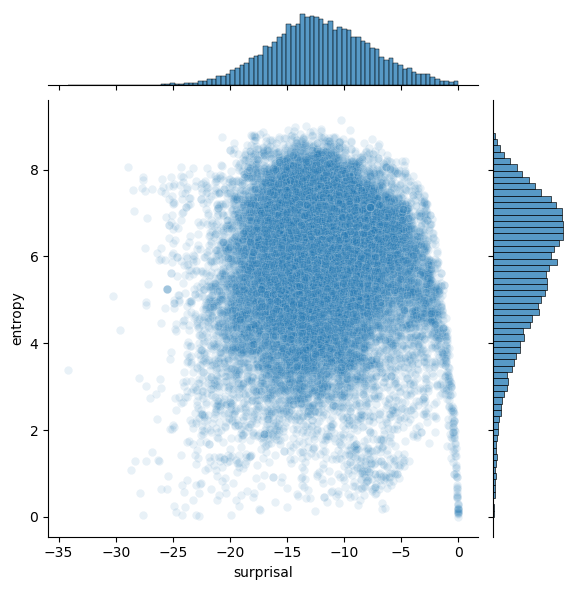

In [32]:
sns.jointplot(data=results_df, x="surprisal", y="entropy", alpha=0.1)

In [33]:
len(matches)

132

In [34]:
merge_count_df = pd.merge(
    results_df[(results_df.entropy.between(4, 5)) & results_df.surprisal.between(-3, 0)].target_word.value_counts().rename("count_low").to_frame(),
    results_df[(results_df.entropy.between(4, 5)) & (results_df.surprisal.between(-15, -10))].target_word.value_counts().rename("count_high").to_frame(),
    how="outer", left_index=True, right_index=True)
merge_count_df

,count_low,count_high
target_word,,
blush,NaN,56
bunk,1.0,50
clay,2.0,33
cramp,2.0,22
daily,1.0,228
filth,NaN,27
fluke,NaN,7
lever,NaN,18
loft,NaN,35


In [35]:
(~merge_count_df.isna()).all(axis=1).sum()

12

In [36]:
if "label" in results_df.columns:
    results_df = results_df.drop(columns=["label"])
results_df.loc[(results_df.entropy.between(4, 5)) & results_df.surprisal.between(-3, 0), "label"] = "low"
results_df.loc[(results_df.entropy.between(4, 5)) & (results_df.surprisal.between(-15, -10)), "label"] = "high"

<Axes: xlabel='label', ylabel='surprisal'>

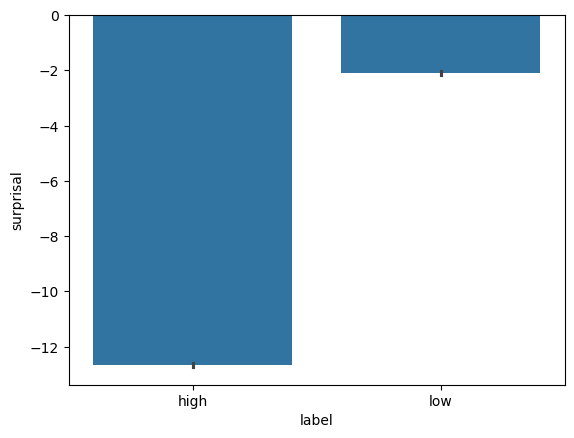

In [37]:
sns.barplot(data=results_df, x="label", y="surprisal")

<Axes: xlabel='label', ylabel='entropy'>

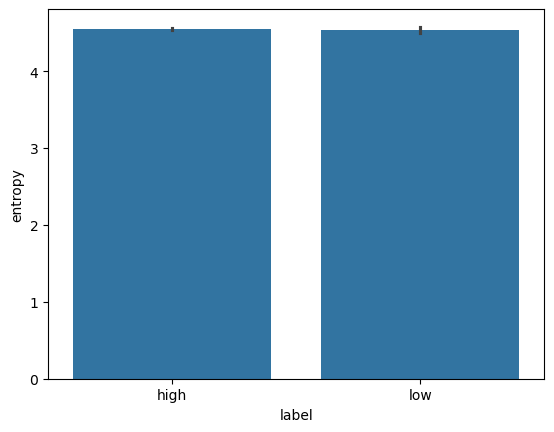

In [38]:
sns.barplot(data=results_df, x="label", y="entropy")

In [42]:
candidate_df

,sentence_idx,found,surprisal,entropy,target_word,label,sentence
9517,525,True,-12.400428,4.339103,blush,high,It makes me blush.
9231,239,True,-12.238396,4.730017,blush,high,Is that lip shade coral blush?
9141,149,True,-12.208710,4.710689,blush,high,The cheeks of the children blush.
9474,482,True,-12.080766,4.685691,blush,high,- To make you blush.
9493,501,True,-11.891634,4.928677,blush,high,They make you blush.
...,...,...,...,...,...,...,...
38,38,True,-11.772165,4.547930,vice,high,Extremism in the name of piety is no vice.
213,213,True,-10.265224,4.916199,vice,high,I don't think smoking is a vice.
400,400,True,-1.489419,4.829265,vice,low,you'll work pro hac vice.
165,165,True,-1.407379,4.766074,vice,low,"For now, you'll work pro hac vice."


In [150]:
# manually add sentences to the filtered set, regardless of their performance in the above
# surprisal/entropy tests

manual_additions = {
    "slave": {
        "low": ["Education liberates, transforming each former slave.",
                "Every human deserves dignity, not to be a slave.",
                "No one should be born a slave.",
                "Liberation movements fight against being a slave."],
        "high": ["The career made him a modern-day slave.",
                 "Despite his success, he felt like a slave.",
                 "The demanding job reduced him to a mere slave.",
                 "Beneath the CEO title, he was a slave.",
                 "Behind the fame, he remained a slave.",
                 "With every promotion, he became more of a slave.",
                 "The timeless melody was composed by a slave."],
    },
    "fluke": {
        "low": ["The weather anomaly was a complete fluke.",
                "The coincidence was merely a fluke."],
        "high": ["Winning the lottery twice was a bizarre fluke.",
                 "The only reason they met was a fluke.",],
    },
    "filth": {
        "high": ["The gourmet kitchen hid years of filth.",
                "Behind the luxury, the mansion was full of filth."],
        "low": ["The back alley reeked of filth.",
                "The neglected basement was covered in filth."],
    },
    "quirk": {
        "high": ["The famous author's writing had a single quirk.",
                "The top athlete's routine included a unique quirk."],
        "low": ["Her impeccable taste had one odd quirk."],
    },
    "blush": {
        "high": ["The robot's face turned red in a blush.",
                "The ice sculpture seemed to blush.",
                "The alien's skin color changed to blush.",
                "The stone statue appeared to blush."],
        "low": ["His compliment made her blush.",
                "The shy girl began to blush.",
                "The romantic gesture made him blush."],
    },
    "clay": {
        "high": ["The skyscraper's core was made of clay.",
                "The computer chip was surprisingly crafted from clay.",
                "The ancient manuscript was preserved in clay."],
        "low": ["The sculpture was made from clay."],
    },
    "cramp": {
        "high": ["The scientist's mind went blank with a cramp.",
                "The chef's creativity halted due to a cramp.",
                "The dancer's elegance was interrupted by a cramp."],
        "low": ["The swimmer stopped due to a cramp.",
                "The hike gave her a painful cramp."],
    },
    "clan": {
        "high": ["The orchestra performed like a unified clan."],
        "low": ["The ancient tribe was known as a powerful clan.",
                "Their family had the strength of a clan."],
    },
    "lever": {
        "high": ["The novel's plot twist hinged on a lever.",
                "The musician's creativity was unlocked by a lever.",
                "The secret passage was revealed by a lever.",
                "The political campaign turned on a strategic lever."],
        "low": ["He pulled the machine's starting lever.",
                "The train's speed was controlled by a lever.",],
    },
    "pout": {
        "high": ["The statue's expression ended in a pout.",
                "The robot's display showed a digital pout.",
                "The serious politician suddenly broke into a pout.",
                "The ancient painting featured a mysterious pout.",
                "The cat's fur pattern resembled a pout."],
        "low": ["She couldn't help but pout.",
                "The toddler's reaction was a persistent pout."],
    },
    "stray": {
        "high": ["The perfectly coded program had one stray.",
                "The symphony was flawless, except for one stray.",
                "Her thoughts contained a single stray.",],
        "low": ["The dog wandered into the yard as a stray.",
                "A leaf blew across the sidewalk as a stray.",
                "The bullet hit the wall as a stray.",],
    },
    "moral": {
        "high": ["The financial report had an unexpected moral.",
                "The action movie concluded with a surprising moral.",
                "The recipe book ended with a moral."],
        "low": ["The fable ended with a clear moral.",
                "Every fairy tale has a moral.",
                "The sermon focused on a strong moral."],
    },
    "sage": {
        "high": ["The barista dispensed guidance like a sage.",
                "The toddler spoke with the tone of a sage.",
                "The cartoon character sounded like a sage."],
        "low": ["The sports coach gave wisdom like a sage."],
    }
    
}


In [151]:
manual_results = []

for target_word, labeled_sentences in tqdm(manual_additions.items()):
    word_sentences = [sentence for sentences in labeled_sentences.values() for sentence in sentences]
    word_sentence_ids = np.arange(len(word_sentences))
    word_labels = [label for label, sentences in labeled_sentences.items() for _ in sentences]

    print(target_word, scorer.tokenizer(" " + target_word).input_ids)
    target_word_tokens = scorer.tokenizer.convert_ids_to_tokens(scorer.tokenizer(" " + target_word)["input_ids"])

    for batch_cursor in trange(0, len(word_sentences), batch_size, unit="batch", leave=False):
        sent_ids_batch = word_sentence_ids[batch_cursor:batch_cursor + batch_size]
        sents_batch = word_sentences[batch_cursor:batch_cursor + batch_size]

        batch_tokens, batch_surprisals, batch_entropies = compute_surprisal_entropy(scorer, sents_batch)

        found_mask = np.zeros((len(sents_batch), 1), dtype=bool)
        sentence_target_values = np.zeros((len(sents_batch), 2))
        for i, sent in enumerate(sents_batch):
            for j in range(len(batch_tokens[i])):
                if batch_tokens[i][j:j+len(target_word_tokens)] == target_word_tokens:
                    sentence_target_values[i, 0] = batch_surprisals[i][j - 1:j - 1 +len(target_word_tokens)].sum().item()
                    sentence_target_values[i, 1] = batch_entropies[i][j - 1].item()
                    found_mask[i] = True

        manual_results.append(
            pd.DataFrame({"target_word": target_word, "sentence_idx": sent_ids_batch, "sentence": sents_batch,
                          "found": found_mask.flatten(), "label": word_labels,
                          "surprisal": sentence_target_values[:, 0],
                          "entropy": sentence_target_values[:, 1]}))

  0%|          | 0/13 [00:00<?, ?it/s]

slave [11778]


  0%|          | 0/1 [00:00<?, ?batch/s]

fluke [781, 4649]


  0%|          | 0/1 [00:00<?, ?batch/s]

filth [1226, 400]


  0%|          | 0/1 [00:00<?, ?batch/s]

quirk [627, 14232]


  0%|          | 0/1 [00:00<?, ?batch/s]

blush [37854]


  0%|          | 0/1 [00:00<?, ?batch/s]

clay [21558]


  0%|          | 0/1 [00:00<?, ?batch/s]

cramp [1067, 696]


  0%|          | 0/1 [00:00<?, ?batch/s]

clan [19065]


  0%|          | 0/1 [00:00<?, ?batch/s]

lever [17124]


  0%|          | 0/1 [00:00<?, ?batch/s]

pout [279, 448]


  0%|          | 0/1 [00:00<?, ?batch/s]

stray [28583]


  0%|          | 0/1 [00:00<?, ?batch/s]

moral [6573]


  0%|          | 0/1 [00:00<?, ?batch/s]

sage [35021]


  0%|          | 0/1 [00:00<?, ?batch/s]

In [167]:
candidate_df = results_df[~results_df.label.isna()].groupby(["target_word", "label"]) \
    .sample(10, replace=True).reset_index()

# add in all manual candidates
candidate_df = pd.concat([candidate_df.assign(manual=False),
                          pd.concat(manual_results).assign(manual=True).reset_index()])
candidate_df = candidate_df.drop_duplicates("sentence").sort_values(["target_word", "label", "surprisal"])

# match column order of the current annotation set
candidate_df = candidate_df[["sentence_idx", "found", "surprisal", "entropy", "target_word", "label", "sentence"]]

candidate_df.to_csv(f"candidate_sentences-{scorer.model.name_or_path.replace('/', '-')}-{sample_id}.csv")